# Melanoma analysis for beginners
[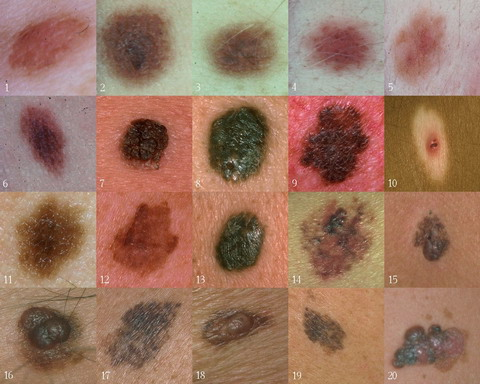]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import random
import cv2

In [ ]:
train_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
sample_submission = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

train_data.rename(columns={
    'anatom_site_general_challenge': 'area', 
    'benign_malignant': 'class',
    'target': 'label'
}, inplace=True)
train_data.head()

Unlike most other Computer vision problems, this problem is more interesting because it has non-image features as well like "area", "sex", "age" and context ie. "patient_id".

In [ ]:
print('unique patient ids: ' + str(len(train_data.patient_id.unique())))

fig, axs = plt.subplots(3,2)
plt.subplots_adjust(left=0.2, bottom=0.2, right=2, top=2.2, wspace=0.4, hspace=1)
plt.xticks(rotation=45)

train_data['class'].value_counts().plot(kind='bar', ax=axs[0][0],legend=True, rot=65, title='class')
train_data['area'].value_counts().plot(kind='bar', ax=axs[0][1], legend=True, rot=65, title='area')
train_data['age_approx'].value_counts().plot(kind='bar', ax=axs[1][1], legend=True, rot=65, title='age')
train_data['diagnosis'].value_counts().plot(kind='bar', ax=axs[1][0], legend=True, rot=65, title='diagnosis')
train_data['sex'].value_counts().plot(kind='bar', ax=axs[2][1], legend=True, rot=65, title='sex')


# Since most of the values is unknown for diagnosis, generating a separate chart for non unknowns
non_na_diagnosis = train_data[['diagnosis']]
non_na_diagnosis = non_na_diagnosis[non_na_diagnosis.diagnosis != 'unknown']

non_na_diagnosis['diagnosis'].value_counts().plot(kind='bar', 
                                                  ax=axs[2][0], legend=True, rot=65, title='Known Diagnosis')

for ax in fig.axes:
    plt.xticks(rotation=75)


plt.show()


In [ ]:
train_data.describe()

# Results
Following top of the head conclusions can be drawn from the tabular data:
1. Lot more "benign" classes than "malignant". Will need to oversample the malignant class during training. Try [SMOTE](https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6).
2. Lots of data for middle aged and older aged patients. This is the expectation since skin cancer is less common in young individuals.
3. Vast proportion of the images, approx. 50% is from torso. Next steps, check if these also have a higher chance of being malignant.


In [ ]:
TRAIN_IMAGES_PATH = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
def plot_images(dataframe, labels, image_count=6):
    """
    Plots image_count random images in a subplot containing 3 columns. Note that before using this function generally,
    please set the TRAIN_IMAGES_PATH global variable to the location where images are stored.
    
    Parameters
    ----------
    dataframe: DataFrame containing just one column which contains image names found under TRAIN_IMAGES_PATH
    image_count: Minimum Number of images to display. Will round of to nearest multiple of 3 since images are 
                displayed in 3 columns and show those images.
    """
    assert dataframe.shape[1] == 1
    assert labels.shape[1] == 1
    size = len(dataframe)
    while image_count % 3 != 0:
        image_count = image_count + 1 

    image_column = dataframe.columns[0]
    label_column = labels.columns[0]
    row_count = (int) (image_count/3)
    fig, ax = plt.subplots(row_count, 3, figsize=(15,15))
    for i in range(row_count):
        for j in range(3):
            index = random.randint(0, size-1)
            tuple_index = (i, j) if row_count > 1 else j
            img_path = TRAIN_IMAGES_PATH + '/' + dataframe.iloc[index][image_column]
            ax[tuple_index].imshow(cv2.imread(img_path))
            ax[tuple_index].set_title('Image: {}, label: {}'.format(index, labels.iloc[index][label_column]))
    fig.show()
    
# Sample usage
train_data['image_name_jpg'] = train_data['image_name'].apply(lambda val : val + '.jpg').values
plot_images(train_data[['image_name_jpg']], train_data[['class']], 9)

# Since most of the data is benign, random selection doesn't generate any malignant observations
# Lets pick some of them and show as well
malignant_data = train_data.loc[train_data['class'] == 'malignant']
plot_images(malignant_data[['image_name_jpg']], malignant_data[['class']], 9)



# Summary of visualizing images
1. It is hard for non-experts to infer based on images what is malignant and what is not. Might be non trivial to compute avoidable bias.
2. For data augmentation, the following functions should be applicable.
* Horizontal and vertical flipping.
* Rotations to different degrees.
* Brightness changes.
* Zooming in.

In [ ]:
# Analysing what percentage of a patient's images has cancer detected if the individual is affected at least
# in one of the image
affected_patients = malignant_data[['patient_id']].values

affected = {}
unaffected = {}

for index, row in train_data.iterrows():
    patient_id = row.patient_id
    if patient_id in affected_patients:
        if row['class'] == 'malignant':
            if patient_id not in affected:
                affected[patient_id] = 0
            current_count = affected[patient_id]
            affected[patient_id] = current_count + 1
        else:
            if patient_id not in unaffected:
                unaffected[patient_id] = 0
            current_count = unaffected[patient_id]
            unaffected[patient_id] = current_count + 1

affected_patients_ratio = pd.DataFrame(columns=['patient_id', 'affected_count', 'unaffected_count'])

index = 0
for key in affected:
    patient_id = key
    unaffected_count = unaffected[key] if key in unaffected else 0
    affected_patients_ratio.loc[index] = [patient_id] + [affected[key]] + [unaffected_count]
    index = index + 1
    
        
affected_patients_ratio.head()

In [ ]:
affected_patients_ratio['percentage_affected_images'] = affected_patients_ratio.apply(
    lambda row : int(100 * row.affected_count / (row.affected_count + row.unaffected_count)), axis=1)

affected_patients_ratio.head()

In [ ]:
affected_patients_ratio['percentage_affected_images'].value_counts(sort=False).plot(
    kind='bar', legend=True, title='percentage', sort_columns=True)

# Summary of analysis
There is not enough organized information around what percentage of a patient's images are going to be malignant if at least one of the images is malignant. However, few things we can note from the plot above:
1. A farily good proportion of affected patients have only under 10% of their images marked as malignant.
2. There are a good proportion of patients for whom either 20%, or 25% or 33% images are marked as malignant.

In final summary, if a patient has cancer, it is not certain that most of the images are going to be marked as malignant.

# Final key takeways
1. When training the CNN for image classification, an oversampling technique is going to be required. The malignant class has severe under representation in the training data.
2. Fortunately, looking at some sample images, it seems that most common data augmentation methods are going to be applicable.
3. Contextual inference will have some value but cannot be a strong signal, ie. if a patience has cancer, doesn't necessarily imply that majority of the images are going to be marked as malignant.

**I hope you can find at least little bit of information in this notebook useful, if yes please don't forget to upvote it :)**

I am new to kaggle and learning, so thought of sharing this early analysis to help speed up other beginners.